In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

# Import processing dataset

In [2]:
train_x = pd.read_csv("train_x.csv")
test_x = pd.read_csv("test_x.csv")
train_x_log = pd.read_csv("train_x_log.csv")
test_x_log = pd.read_csv("test_x_log.csv")
train_x_eng_with_KNN_TSNE_KMean = pd.read_csv("train_x_eng_with_KNN_TSNE_KMean.csv")
test_x_eng_with_KNN_TSNE_Kmean = pd.read_csv("test_x_eng_with_KNN_TSNE_Kmean.csv")
train_x_log_eng_with_KNN_TSNE_KMean = pd.read_csv("train_x_log_eng_with_KNN_TSNE_KMean.csv")
test_x_log_eng_with_KNN_TSNE_Kmean = pd.read_csv("test_x_log_eng_with_KNN_TSNE_Kmean.csv")
train_y_class = pd.read_csv("train_y_class.csv")
train_y_label = pd.read_csv("train_y_label.csv")

Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
# Total dataset features to consider
print(train_x.shape)
print(test_x.shape)
print(train_x_log.shape)
print(test_x_log.shape)
print(train_x_eng_with_KNN_TSNE_KMean.shape)
print(test_x_eng_with_KNN_TSNE_Kmean.shape)
print(train_x_log_eng_with_KNN_TSNE_KMean.shape)
print(test_x_log_eng_with_KNN_TSNE_Kmean.shape)

# Label dataset
print(train_y_class.shape)
print(train_y_label.shape)

(61878, 93)
(144368, 93)
(61878, 93)
(144368, 93)
(61878, 227)
(144368, 227)
(61878, 227)
(144368, 227)
(61878, 9)
(61878, 1)


# 1. XGBoost, Grid Search with train_x, train_y_label

In [4]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [5]:
hyperparameters_dict = {"learning_rate": [0.1,0.2,0.3],              # range: [0,1], default = 0.3
                   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
                   # The larger gamma is, the more conservative the algorithm will be.                   
                   "gamma": [i/10.0 for i in range(1,10,2)],
                   # Maximum depth of a tree. 
                   # Increasing this value will make the model more complex and more likely to overfit
                   "max_depth": [6], 
                   # Used to control over-fitting
                   # Too high values can lead to under-fitting hence, it should be tuned using grid search
                   "min_child_weight": [1],
                   # Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced
                   "max_delta_step": [0],
                   # Denotes the fraction of observations to be randomly samples for each tree
                   # Typical values: 0.5-1
                   "subsample": [0.8],
                   # Similar to max_features in GBM, Typical values: 0.5 - 1
                   # Denotes the fraction of columns to be randomly samples for each tree.
                   "colsample_bytree": [0.8,1],
                   "colsample_bylevel": [1], # colsample_bytree will control the decision over this, default = 1
                   "colsample_bynode": [1],  # colsample_bytree will control the decision over this, default = 1
                   # L2 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_lambda": [1], # default = 1
                   # L1 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_alpha": [1],  # default = 0
                   # Control the balance of positive and negative weights, useful for unbalanced classes. 
                   # A typical value to consider: sum(negative instances) / sum(positive instances)
                   "scale_pos_weight": [1],
                   # No. of trees ensemble, too high sometimes still can cause overfitting
                   "n_estimators": [300,400], 
                   "booster": ["gbtree"],
                   "verbosity": [1],
                   "objective": ["reg:squarederror"],
                   "seed": [50]
                   }

In [6]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [7]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [5],                     # 1st to tune
                          'min_child_weight': [1],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.8],                   # 4th
                          'colsample_bytree': [0.6],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [8]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [9]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [10]:
xgboost_grid.fit(train_x,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [5], 'min_child_weight': [1], 'max_delta_step': [0], 'subsample': [0.8], 'colsample_bytree': [0.6], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pre_

In [11]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.8105953945043416
0.8606289796050293
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.8, verbosity=1)


In [12]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.8105953945043416]
[0.8606289796050293]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.8, verbosity=1)]


# XGBoost_test_x Prediction for Ensemble Model before optimize boosting

In [13]:
XGBoost_test_x_prior_pred = best_rf.predict_proba(test_x)

In [14]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_prior_pred

In [15]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_prior_pred.csv",index=False)

# XGBoost_train_x Prediction for Ensemble Model before optimize boosting

In [16]:
XGBoost_train_x_prior_pred = best_rf.predict_proba(train_x)

In [17]:
XGBoost_train_x_prior_pred = pd.DataFrame(XGBoost_train_x_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [18]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_prior_pred.to_csv("XGBoost_train_x_prior_pred.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [19]:
trainDMat = xgb.DMatrix(data = train_x, label = train_y_label)

In [20]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [21]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 5,                     # 1st to tune
                          'min_child_weight': 1,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.8,                   # 4th
                          'colsample_bytree': 0.6,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [22]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.34255+0.0020229	test-merror:0.35153+0.00322275
[1]	train-merror:0.286278+0.00594661	test-merror:0.295856+0.00445336
[2]	train-merror:0.274869+0.00365563	test-merror:0.283962+0.00244747
[3]	train-merror:0.263028+0.00308442	test-merror:0.273086+0.00549032
[4]	train-merror:0.25679+0.00202508	test-merror:0.267591+0.00201708
[5]	train-merror:0.251796+0.00241358	test-merror:0.262064+0.00170555
[6]	train-merror:0.249108+0.00246054	test-merror:0.259543+0.00282942
[7]	train-merror:0.245898+0.00219601	test-merror:0.256068+0.00190688
[8]	train-merror:0.243905+0.00221821	test-merror:0.255632+0.00166016
[9]	train-merror:0.242353+0.00198624	test-merror:0.253418+0.00206794
[10]	train-merror:0.241028+0.00220265	test-merror:0.2524+0.00184661
[11]	train-merror:0.239509+0.00209465	test-merror:0.250655+0.000730589
[12]	train-merror:0.237764+0.00237503	test-merror:0.248877+0.00161249
[13]	train-merror:0.236691+0.00249659	test-merror:0.247633+0.00171951
[14]	train-merror:0.234882+0.002506

[117]	train-merror:0.167405+0.000506672	test-merror:0.202059+0.00284432
[118]	train-merror:0.167157+0.000595467	test-merror:0.201962+0.00291597
[119]	train-merror:0.16685+0.000685221	test-merror:0.201655+0.00261069
[120]	train-merror:0.166371+0.00059387	test-merror:0.201574+0.00270717
[121]	train-merror:0.165805+0.000702284	test-merror:0.201412+0.00264777
[122]	train-merror:0.165536+0.00078754	test-merror:0.201348+0.00239634
[123]	train-merror:0.165229+0.000759564	test-merror:0.201299+0.00253936
[124]	train-merror:0.164873+0.000934986	test-merror:0.201105+0.00253339
[125]	train-merror:0.164436+0.000851767	test-merror:0.200927+0.00255395
[126]	train-merror:0.163817+0.000914799	test-merror:0.200814+0.0025587
[127]	train-merror:0.163488+0.000972433	test-merror:0.200766+0.00282703
[128]	train-merror:0.163262+0.000933644	test-merror:0.200572+0.00256801
[129]	train-merror:0.162907+0.00100328	test-merror:0.200523+0.00268434
[130]	train-merror:0.162427+0.000884821	test-merror:0.200297+0.002382

[233]	train-merror:0.133952+0.00114758	test-merror:0.190827+0.00329366
[234]	train-merror:0.133683+0.00121262	test-merror:0.190827+0.00338185
[235]	train-merror:0.133457+0.00122839	test-merror:0.190666+0.00331229
[236]	train-merror:0.133251+0.00115963	test-merror:0.190682+0.00350726
[237]	train-merror:0.132961+0.00116669	test-merror:0.190649+0.00326461
[238]	train-merror:0.132767+0.00103634	test-merror:0.190584+0.00309726
[239]	train-merror:0.13247+0.00105055	test-merror:0.190536+0.00291282
[240]	train-merror:0.132303+0.00125735	test-merror:0.190488+0.00288633
[241]	train-merror:0.132077+0.00119145	test-merror:0.190552+0.00312479
[242]	train-merror:0.131754+0.00114785	test-merror:0.19052+0.00298251
[243]	train-merror:0.131533+0.0010517	test-merror:0.190455+0.00296992
[244]	train-merror:0.131345+0.00106962	test-merror:0.190229+0.00288562
[245]	train-merror:0.13121+0.00116048	test-merror:0.189938+0.00308003
[246]	train-merror:0.130935+0.00107623	test-merror:0.18997+0.00330043
[247]	train

[348]	train-merror:0.110868+0.0009602	test-merror:0.185445+0.00288032
[349]	train-merror:0.11068+0.000945379	test-merror:0.185316+0.00280306
[350]	train-merror:0.110513+0.000930335	test-merror:0.185235+0.00306685
[351]	train-merror:0.110319+0.00087971	test-merror:0.185057+0.00299852
[352]	train-merror:0.110125+0.000845517	test-merror:0.185041+0.00291204
[353]	train-merror:0.109985+0.000825744	test-merror:0.185057+0.00300412
[354]	train-merror:0.10978+0.000861756	test-merror:0.185106+0.00302975
[355]	train-merror:0.109646+0.000792686	test-merror:0.185187+0.00293899
[356]	train-merror:0.109473+0.000834715	test-merror:0.185041+0.002919
[357]	train-merror:0.109328+0.000926657	test-merror:0.18509+0.00298073
[358]	train-merror:0.10922+0.000951356	test-merror:0.185074+0.00293072
[359]	train-merror:0.109097+0.00118851	test-merror:0.184864+0.00275537
[360]	train-merror:0.108924+0.00122853	test-merror:0.184977+0.00267605
[361]	train-merror:0.108681+0.00126777	test-merror:0.184993+0.00273914
[362

[463]	train-merror:0.092456+0.000710015	test-merror:0.182391+0.00227558
[464]	train-merror:0.092343+0.000664686	test-merror:0.182327+0.00236993
[465]	train-merror:0.092246+0.000727873	test-merror:0.182391+0.00244363
[466]	train-merror:0.0921597+0.000709398	test-merror:0.182213+0.00237333
[467]	train-merror:0.0919983+0.000625916	test-merror:0.182181+0.00239946
[468]	train-merror:0.0917395+0.000645956	test-merror:0.182246+0.00235292
[469]	train-merror:0.0916478+0.000689419	test-merror:0.182229+0.00238084
[470]	train-merror:0.091535+0.000615095	test-merror:0.182003+0.00253753
[471]	train-merror:0.0914058+0.000623341	test-merror:0.181793+0.00263946
[472]	train-merror:0.0913085+0.000625448	test-merror:0.182003+0.00267696
[473]	train-merror:0.091271+0.000562938	test-merror:0.18189+0.00270726
[474]	train-merror:0.0910825+0.000613152	test-merror:0.18202+0.00276534
[475]	train-merror:0.0910825+0.00057394	test-merror:0.181761+0.00283294
[476]	train-merror:0.0909048+0.00056051	test-merror:0.18176

[577]	train-merror:0.0789405+0.000613737	test-merror:0.180209+0.00273472
[578]	train-merror:0.078838+0.000564059	test-merror:0.180015+0.00283814
[579]	train-merror:0.0787515+0.000576845	test-merror:0.179951+0.00283083
[580]	train-merror:0.078671+0.000566266	test-merror:0.179919+0.00280527
[581]	train-merror:0.0784715+0.000613979	test-merror:0.179789+0.00289854
[582]	train-merror:0.0783695+0.000690998	test-merror:0.179725+0.00282127
[583]	train-merror:0.0782885+0.000649191	test-merror:0.179676+0.00292129
[584]	train-merror:0.0781645+0.000660175	test-merror:0.17974+0.0029073
[585]	train-merror:0.0780785+0.000594672	test-merror:0.179918+0.00279303
[586]	train-merror:0.0780192+0.000616123	test-merror:0.179724+0.00263119
[587]	train-merror:0.07789+0.000621544	test-merror:0.179595+0.00267356
[588]	train-merror:0.077852+0.000504753	test-merror:0.179547+0.00250915
[589]	train-merror:0.0777012+0.000601876	test-merror:0.179789+0.00257181
[590]	train-merror:0.0776312+0.000651813	test-merror:0.179

[691]	train-merror:0.0679295+0.000562941	test-merror:0.177979+0.00207209
[692]	train-merror:0.0678807+0.000485557	test-merror:0.177801+0.00205503
[693]	train-merror:0.0678003+0.000474869	test-merror:0.177608+0.00216913
[694]	train-merror:0.0676705+0.000477622	test-merror:0.17764+0.00223782
[695]	train-merror:0.0675145+0.000499233	test-merror:0.177656+0.00217687
[696]	train-merror:0.067466+0.000468433	test-merror:0.177575+0.00223528
[697]	train-merror:0.0674015+0.00049072	test-merror:0.177672+0.00227216
[698]	train-merror:0.067186+0.000559068	test-merror:0.177591+0.00220772
[699]	train-merror:0.067132+0.000504862	test-merror:0.177478+0.00231021
[700]	train-merror:0.0671212+0.000501446	test-merror:0.17751+0.00226142
[701]	train-merror:0.0668953+0.000465183	test-merror:0.177575+0.00230604
[702]	train-merror:0.0667872+0.000523177	test-merror:0.17743+0.00227588
[703]	train-merror:0.0667172+0.000464095	test-merror:0.177252+0.00226626
[704]	train-merror:0.0665557+0.000489076	test-merror:0.177

# Finalise XGBoost Model

In [23]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

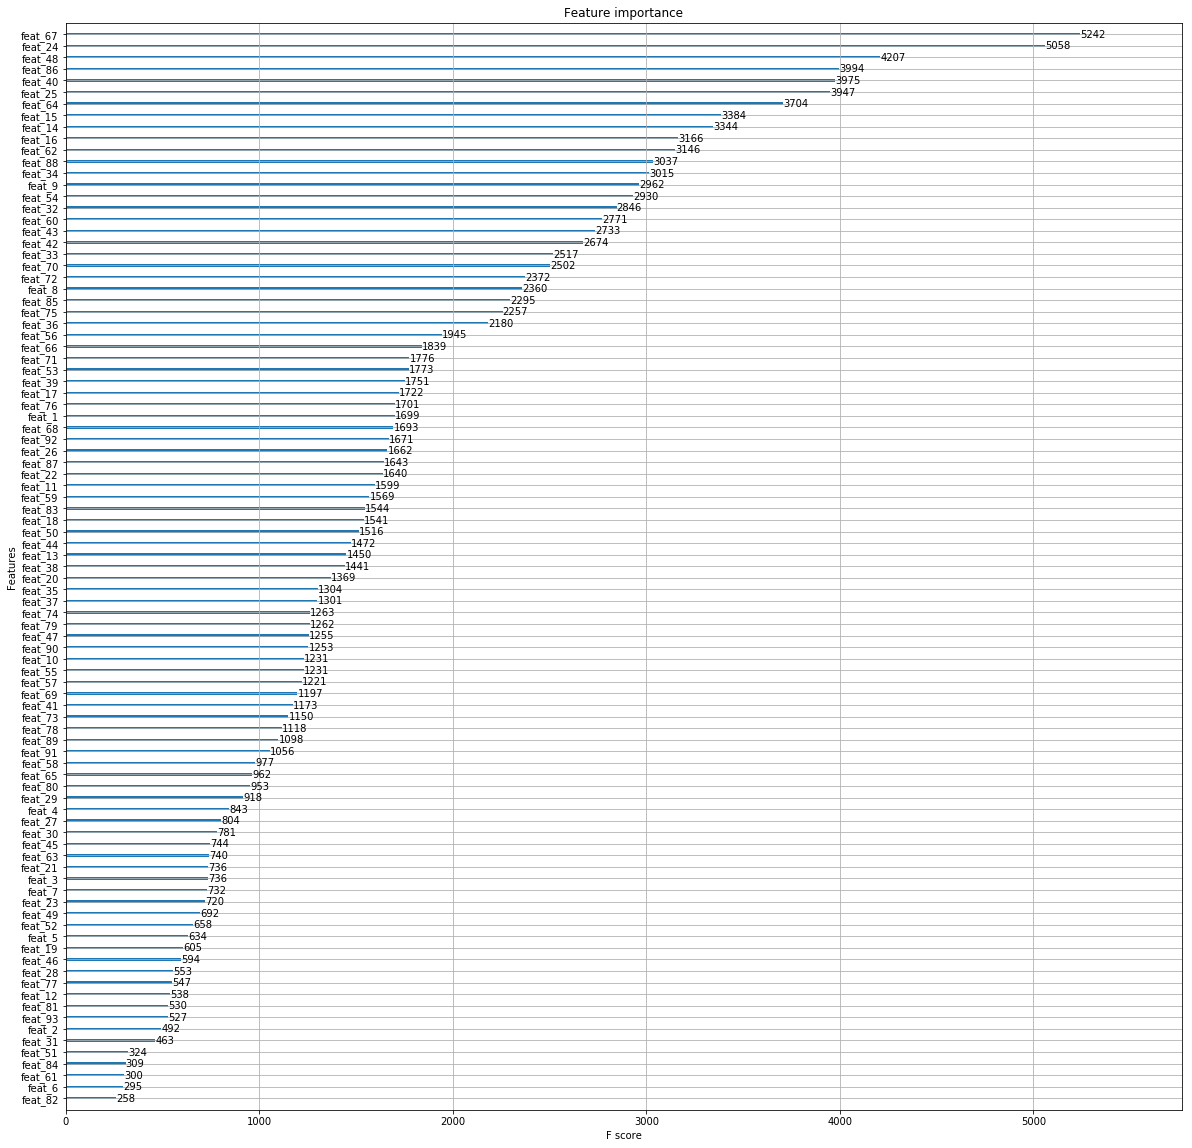

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x Prediction for Ensemble Model After optimize boosting

In [25]:
XGBoost_test_x_pred = xgbFinal.predict(xgb.DMatrix(test_x))

In [26]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_pred

In [27]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_pred.csv",index=False)

# XGBoost_train_x Prediction for Ensemble Model After optimize boosting

In [28]:
XGBoost_train_x_pred = xgbFinal.predict(xgb.DMatrix(train_x))

In [29]:
XGBoost_train_x_pred = pd.DataFrame(XGBoost_train_x_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [30]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_pred.to_csv("XGBoost_train_x_pred.csv",index=False)

# Saving the final model

In [31]:
pickle.dump(xgbFinal, open("XGBoost_train_x_model.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_model = pickle.load(open("XGBoost_train_x_model.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_model_pred = XGBoost_train_x_model.predict(xgb.DMatrix(test_x))

# 2. XGBoost, Grid Search with train_x_log, train_y_label

In [32]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [33]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [34]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [5],                     # 1st to tune
                          'min_child_weight': [1],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.8],                   # 4th
                          'colsample_bytree': [0.6],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [35]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [36]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [37]:
xgboost_grid.fit(train_x_log,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [5], 'min_child_weight': [1], 'max_delta_step': [0], 'subsample': [0.8], 'colsample_bytree': [0.6], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pre_

In [38]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_log,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.8108216294610153
0.8611138045832121
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.8, verbosity=1)


In [39]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.8108216294610153]
[0.8611138045832121]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.8, verbosity=1)]


# XGBoost_test_x_log Prediction for Ensemble Model before optimize boosting

In [40]:
XGBoost_test_x_log_prior_pred = best_rf.predict_proba(test_x_log)

In [41]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_prior_pred

In [42]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_prior_pred.csv",index=False)

# XGBoost_train_x_log Prediction for Ensemble Model before optimize boosting

In [43]:
XGBoost_train_x_log_prior_pred = best_rf.predict_proba(train_x_log)

In [44]:
XGBoost_train_x_log_prior_pred = pd.DataFrame(XGBoost_train_x_log_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [45]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_prior_pred.to_csv("XGBoost_train_x_log_prior_pred.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [46]:
trainDMat = xgb.DMatrix(data = train_x_log, label = train_y_label)

In [47]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [48]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 5,                     # 1st to tune
                          'min_child_weight': 1,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.8,                   # 4th
                          'colsample_bytree': 0.6,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [49]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.34255+0.0020229	test-merror:0.35153+0.00322275
[1]	train-merror:0.286278+0.00594661	test-merror:0.295856+0.00445336
[2]	train-merror:0.274869+0.00365563	test-merror:0.283962+0.00244747
[3]	train-merror:0.263028+0.00308442	test-merror:0.273086+0.00549032
[4]	train-merror:0.25679+0.00202508	test-merror:0.267591+0.00201708
[5]	train-merror:0.251796+0.00241358	test-merror:0.262064+0.00170555
[6]	train-merror:0.249108+0.00246054	test-merror:0.259543+0.00282942
[7]	train-merror:0.245898+0.00219601	test-merror:0.256068+0.00190688
[8]	train-merror:0.243905+0.00221821	test-merror:0.255616+0.00164874
[9]	train-merror:0.242353+0.00198624	test-merror:0.253402+0.00204623
[10]	train-merror:0.241028+0.00220265	test-merror:0.252384+0.00182817
[11]	train-merror:0.239509+0.00209465	test-merror:0.250638+0.000703851
[12]	train-merror:0.237764+0.00237503	test-merror:0.248861+0.00158638
[13]	train-merror:0.236691+0.00249659	test-merror:0.247633+0.00171951
[14]	train-merror:0.234882+0.0025

[117]	train-merror:0.16734+0.000573056	test-merror:0.202721+0.00300166
[118]	train-merror:0.167081+0.000516923	test-merror:0.202527+0.00302104
[119]	train-merror:0.166688+0.00062626	test-merror:0.202269+0.00277335
[120]	train-merror:0.166371+0.000658262	test-merror:0.202107+0.00270009
[121]	train-merror:0.166009+0.00056432	test-merror:0.201736+0.00258282
[122]	train-merror:0.165697+0.000594047	test-merror:0.201655+0.00277593
[123]	train-merror:0.165352+0.000595238	test-merror:0.201445+0.00270141
[124]	train-merror:0.165035+0.00067813	test-merror:0.20138+0.00262147
[125]	train-merror:0.164636+0.000632945	test-merror:0.201138+0.00257768
[126]	train-merror:0.164291+0.000643297	test-merror:0.201025+0.00251536
[127]	train-merror:0.163984+0.000656404	test-merror:0.200992+0.00264478
[128]	train-merror:0.163585+0.000752699	test-merror:0.200847+0.00263438
[129]	train-merror:0.163262+0.000837685	test-merror:0.200863+0.00260126
[130]	train-merror:0.162977+0.000750177	test-merror:0.200863+0.002369

[232]	train-merror:0.134749+0.000724841	test-merror:0.191264+0.00360392
[233]	train-merror:0.134464+0.000732501	test-merror:0.191134+0.00339234
[234]	train-merror:0.134151+0.000748067	test-merror:0.191085+0.0034552
[235]	train-merror:0.133957+0.000677127	test-merror:0.19115+0.00347961
[236]	train-merror:0.133709+0.000647626	test-merror:0.191037+0.0036278
[237]	train-merror:0.133418+0.000697624	test-merror:0.190811+0.00364311
[238]	train-merror:0.133181+0.000741746	test-merror:0.190811+0.00363068
[239]	train-merror:0.133036+0.000734913	test-merror:0.190827+0.00368352
[240]	train-merror:0.132766+0.000822922	test-merror:0.190698+0.0038114
[241]	train-merror:0.1326+0.000784935	test-merror:0.190536+0.00364121
[242]	train-merror:0.132389+0.000936536	test-merror:0.190439+0.00360891
[243]	train-merror:0.132088+0.000937069	test-merror:0.190455+0.0034798
[244]	train-merror:0.131748+0.000958992	test-merror:0.190472+0.00389397
[245]	train-merror:0.131657+0.000904972	test-merror:0.190471+0.00399806

[347]	train-merror:0.112081+0.000656704	test-merror:0.185187+0.002889
[348]	train-merror:0.111812+0.000595099	test-merror:0.185284+0.00295586
[349]	train-merror:0.111569+0.000607795	test-merror:0.185348+0.00302805
[350]	train-merror:0.111192+0.000560095	test-merror:0.185171+0.00315467
[351]	train-merror:0.111095+0.00057418	test-merror:0.184977+0.00304279
[352]	train-merror:0.110944+0.000548573	test-merror:0.184928+0.00293789
[353]	train-merror:0.110729+0.000626312	test-merror:0.184783+0.00280468
[354]	train-merror:0.110621+0.000671433	test-merror:0.184735+0.00293358
[355]	train-merror:0.110395+0.000655908	test-merror:0.184589+0.0028629
[356]	train-merror:0.110142+0.000665744	test-merror:0.184605+0.00279186
[357]	train-merror:0.109948+0.000657682	test-merror:0.18454+0.00270581
[358]	train-merror:0.109694+0.00066699	test-merror:0.184686+0.00284944
[359]	train-merror:0.109495+0.000688401	test-merror:0.184476+0.00273138
[360]	train-merror:0.109339+0.000694475	test-merror:0.184557+0.0026446

[461]	train-merror:0.0931563+0.000567827	test-merror:0.181244+0.0027549
[462]	train-merror:0.0929085+0.000509084	test-merror:0.180888+0.00293638
[463]	train-merror:0.0927903+0.000634762	test-merror:0.181098+0.00297734
[464]	train-merror:0.092607+0.000664845	test-merror:0.180775+0.0030808
[465]	train-merror:0.0925692+0.00061104	test-merror:0.180969+0.00297174
[466]	train-merror:0.092526+0.000669907	test-merror:0.181018+0.00300331
[467]	train-merror:0.0923105+0.000631965	test-merror:0.181066+0.00311255
[468]	train-merror:0.0921545+0.000715279	test-merror:0.181146+0.00307452
[469]	train-merror:0.0919602+0.000726943	test-merror:0.180969+0.00292366
[470]	train-merror:0.0918472+0.000861189	test-merror:0.180872+0.0031489
[471]	train-merror:0.0916747+0.000882459	test-merror:0.180775+0.00306647
[472]	train-merror:0.0917232+0.000878629	test-merror:0.180791+0.00301306
[473]	train-merror:0.0915887+0.000806807	test-merror:0.180985+0.00297547
[474]	train-merror:0.0913303+0.000809571	test-merror:0.18

[575]	train-merror:0.0791235+0.00102051	test-merror:0.179595+0.00314804
[576]	train-merror:0.0791072+0.00101792	test-merror:0.179547+0.00296878
[577]	train-merror:0.0789403+0.000984006	test-merror:0.179385+0.00300925
[578]	train-merror:0.0788328+0.00100287	test-merror:0.179337+0.00308425
[579]	train-merror:0.0787517+0.000998617	test-merror:0.179111+0.00315164
[580]	train-merror:0.07866+0.000954229	test-merror:0.179094+0.00301838
[581]	train-merror:0.0784878+0.000991903	test-merror:0.179159+0.00325612
[582]	train-merror:0.0784285+0.000948526	test-merror:0.179288+0.00311483
[583]	train-merror:0.0783532+0.00094608	test-merror:0.179014+0.00315191
[584]	train-merror:0.0782993+0.000985311	test-merror:0.179013+0.00309846
[585]	train-merror:0.0781808+0.000912954	test-merror:0.179095+0.00301782
[586]	train-merror:0.0781915+0.000931795	test-merror:0.179046+0.00302118
[587]	train-merror:0.0781323+0.000980698	test-merror:0.178981+0.00319484
[588]	train-merror:0.077976+0.000955065	test-merror:0.178

[689]	train-merror:0.068064+0.000523739	test-merror:0.177284+0.00265405
[690]	train-merror:0.0679512+0.000456341	test-merror:0.177284+0.00265027
[691]	train-merror:0.0678863+0.00046708	test-merror:0.177187+0.00261467
[692]	train-merror:0.067838+0.000440576	test-merror:0.177317+0.0025828
[693]	train-merror:0.0677787+0.000471006	test-merror:0.177316+0.0025919
[694]	train-merror:0.067644+0.000490281	test-merror:0.177397+0.00270546
[695]	train-merror:0.0676062+0.000405499	test-merror:0.177446+0.00280327
[696]	train-merror:0.067423+0.000453265	test-merror:0.177592+0.00297736
[697]	train-merror:0.0673475+0.000369708	test-merror:0.177704+0.00292444
[698]	train-merror:0.0672558+0.000408767	test-merror:0.177575+0.00270879
[699]	train-merror:0.0671593+0.000413096	test-merror:0.177316+0.00270808
[700]	train-merror:0.067132+0.000405838	test-merror:0.177268+0.00255738
[701]	train-merror:0.066949+0.000388158	test-merror:0.177058+0.00252034
[702]	train-merror:0.0669008+0.000309048	test-merror:0.17728

[803]	train-merror:0.059041+0.000323782	test-merror:0.175749+0.00331764
[804]	train-merror:0.0589653+0.000392739	test-merror:0.175684+0.00302228
[805]	train-merror:0.0589493+0.000373561	test-merror:0.175684+0.00305652
[806]	train-merror:0.0588685+0.000280259	test-merror:0.17562+0.00323376
[807]	train-merror:0.0587768+0.000312025	test-merror:0.175588+0.00314312
[808]	train-merror:0.0586907+0.000300441	test-merror:0.175684+0.00302581
[809]	train-merror:0.0586207+0.000348359	test-merror:0.175636+0.00307404
[810]	train-merror:0.0585618+0.000345041	test-merror:0.175781+0.00283689
[811]	train-merror:0.0584538+0.000374991	test-merror:0.175846+0.00294676
[812]	train-merror:0.058384+0.000360276	test-merror:0.175991+0.00291458
[813]	train-merror:0.0582813+0.00033968	test-merror:0.175878+0.00307178
[814]	train-merror:0.0582165+0.00023112	test-merror:0.175781+0.00307311
[815]	train-merror:0.0581627+0.00024444	test-merror:0.175959+0.00303316
[816]	train-merror:0.0581198+0.000230019	test-merror:0.17

# Finalise XGBoost Model

In [50]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

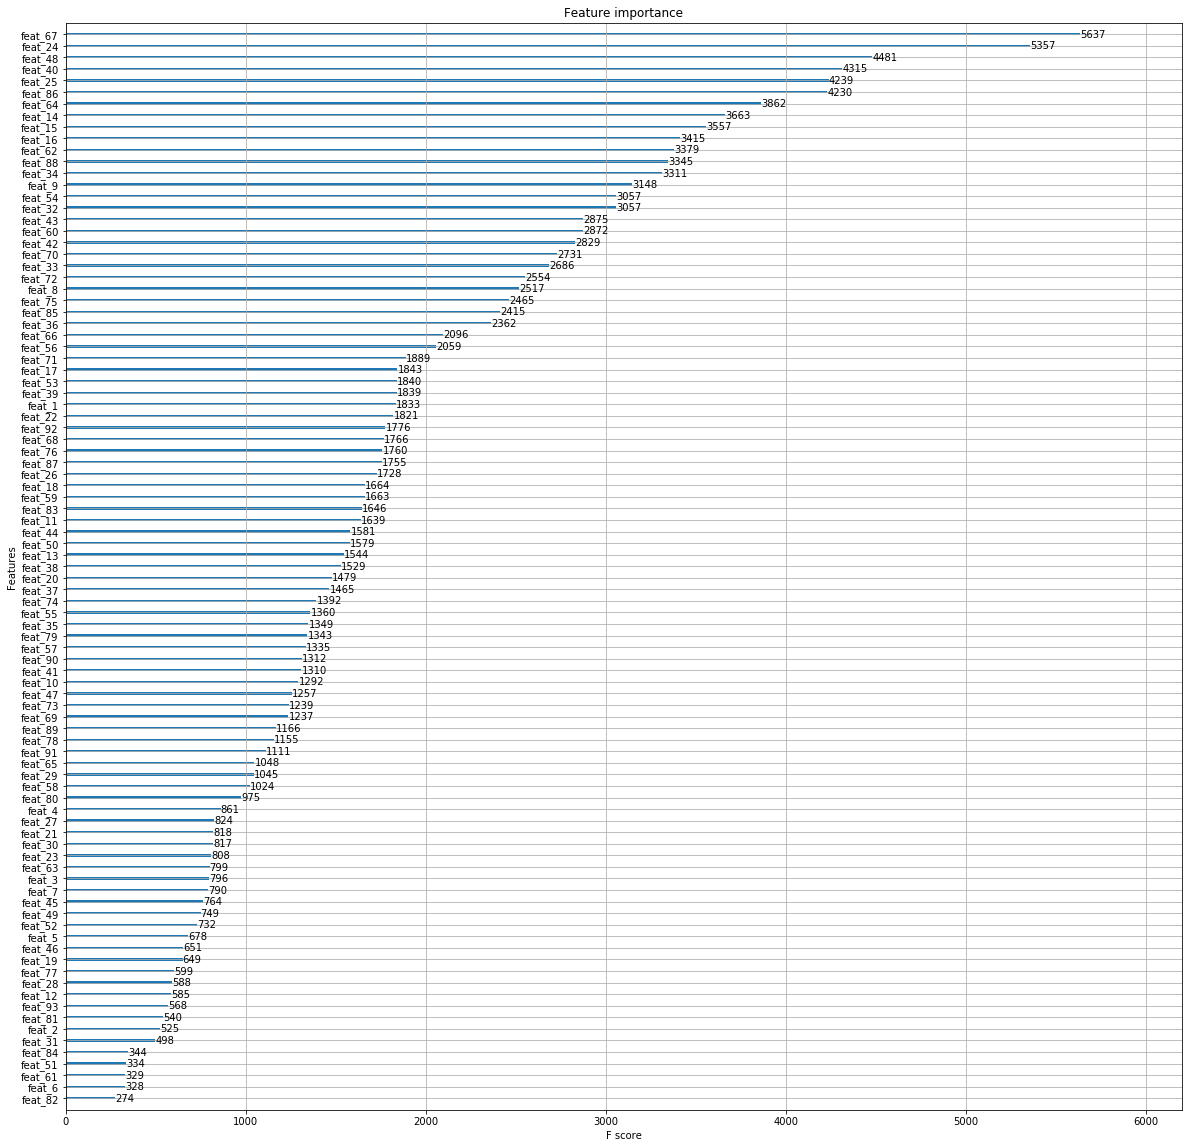

In [51]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_log Prediction for Ensemble Model After optimize boosting

In [52]:
XGBoost_test_x_log_pred = xgbFinal.predict(xgb.DMatrix(test_x_log))

In [53]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_pred

In [54]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_pred.csv",index=False)

# XGBoost_train_x_log Prediction for Ensemble Model After optimize boosting

In [55]:
XGBoost_train_x_log_pred = xgbFinal.predict(xgb.DMatrix(train_x_log))

In [56]:
XGBoost_train_x_log_pred = pd.DataFrame(XGBoost_train_x_log_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [57]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_pred.to_csv("XGBoost_train_x_log_pred.csv",index=False)

# Saving the final model

In [58]:
pickle.dump(xgbFinal, open("XGBoost_train_x_log_model.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_log_model = pickle.load(open("XGBoost_train_x_log_model.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_log_model_pred = XGBoost_train_x_log_model.predict(xgb.DMatrix(test_x_log))

# 3. XGBoost, Grid Search with 
# train_x_eng_with_KNN_TSNE_KMean, train_y_label

In [59]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [60]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [61]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [0],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.78],                   # 4th
                          'colsample_bytree': [0.78],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [62]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [63]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [64]:
xgboost_grid.fit(train_x_eng_with_KNN_TSNE_KMean,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [0], 'max_delta_step': [0], 'subsample': [0.78], 'colsample_bytree': [0.78], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pr

In [65]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_eng_with_KNN_TSNE_KMean,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.9024534005468029
0.9894146546430073
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)


In [66]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.9024534005468029]
[0.9894146546430073]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)]


# XGBoost_test_x_eng_with_KNN_TSNE_Kmean, Prediction for Ensemble Model before optimize boosting

In [67]:
XGBoost_test_x_eng_prior_pred = best_rf.predict_proba(test_x_eng_with_KNN_TSNE_Kmean)

In [68]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_eng_prior_pred

In [69]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_eng_prior_pred.csv",index=False)

# XGBoost_train_x_eng_with_KNN_TSNE_Kmean, Prediction for Ensemble Model before optimize boosting

In [70]:
XGBoost_train_x_eng_prior_pred = best_rf.predict_proba(train_x_eng_with_KNN_TSNE_KMean)

In [71]:
XGBoost_train_x_eng_prior_pred = pd.DataFrame(XGBoost_train_x_eng_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [72]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_eng_prior_pred.to_csv("XGBoost_train_x_eng_prior_pred.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [73]:
trainDMat = xgb.DMatrix(data = train_x_eng_with_KNN_TSNE_KMean, label = train_y_label)

In [74]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [75]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 0,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.78,                   # 4th
                          'colsample_bytree': 0.78,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [76]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.087317+0.00218579	test-merror:0.101054+0.00292165
[1]	train-merror:0.0811058+0.00109609	test-merror:0.0987587+0.00270625
[2]	train-merror:0.0784018+0.00125574	test-merror:0.098533+0.00307839
[3]	train-merror:0.075245+0.00112209	test-merror:0.0966257+0.00226182
[4]	train-merror:0.0732085+0.00150879	test-merror:0.0961733+0.00223434
[5]	train-merror:0.0713877+0.00172334	test-merror:0.096076+0.00248995
[6]	train-merror:0.0701217+0.00176207	test-merror:0.0957533+0.0021889
[7]	train-merror:0.0686565+0.00170974	test-merror:0.0958497+0.0019271
[8]	train-merror:0.067186+0.00135579	test-merror:0.0954783+0.00191423
[9]	train-merror:0.0664805+0.00114829	test-merror:0.0958337+0.00193555
[10]	train-merror:0.065295+0.0013545	test-merror:0.0954135+0.00188574
[11]	train-merror:0.0647132+0.00131242	test-merror:0.095171+0.00157349
[12]	train-merror:0.0638675+0.00148877	test-merror:0.0949933+0.000990621
[13]	train-merror:0.0633237+0.00137903	test-merror:0.0943308+0.00108683
[14]	train-m

# Finalise XGBoost Model

In [77]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

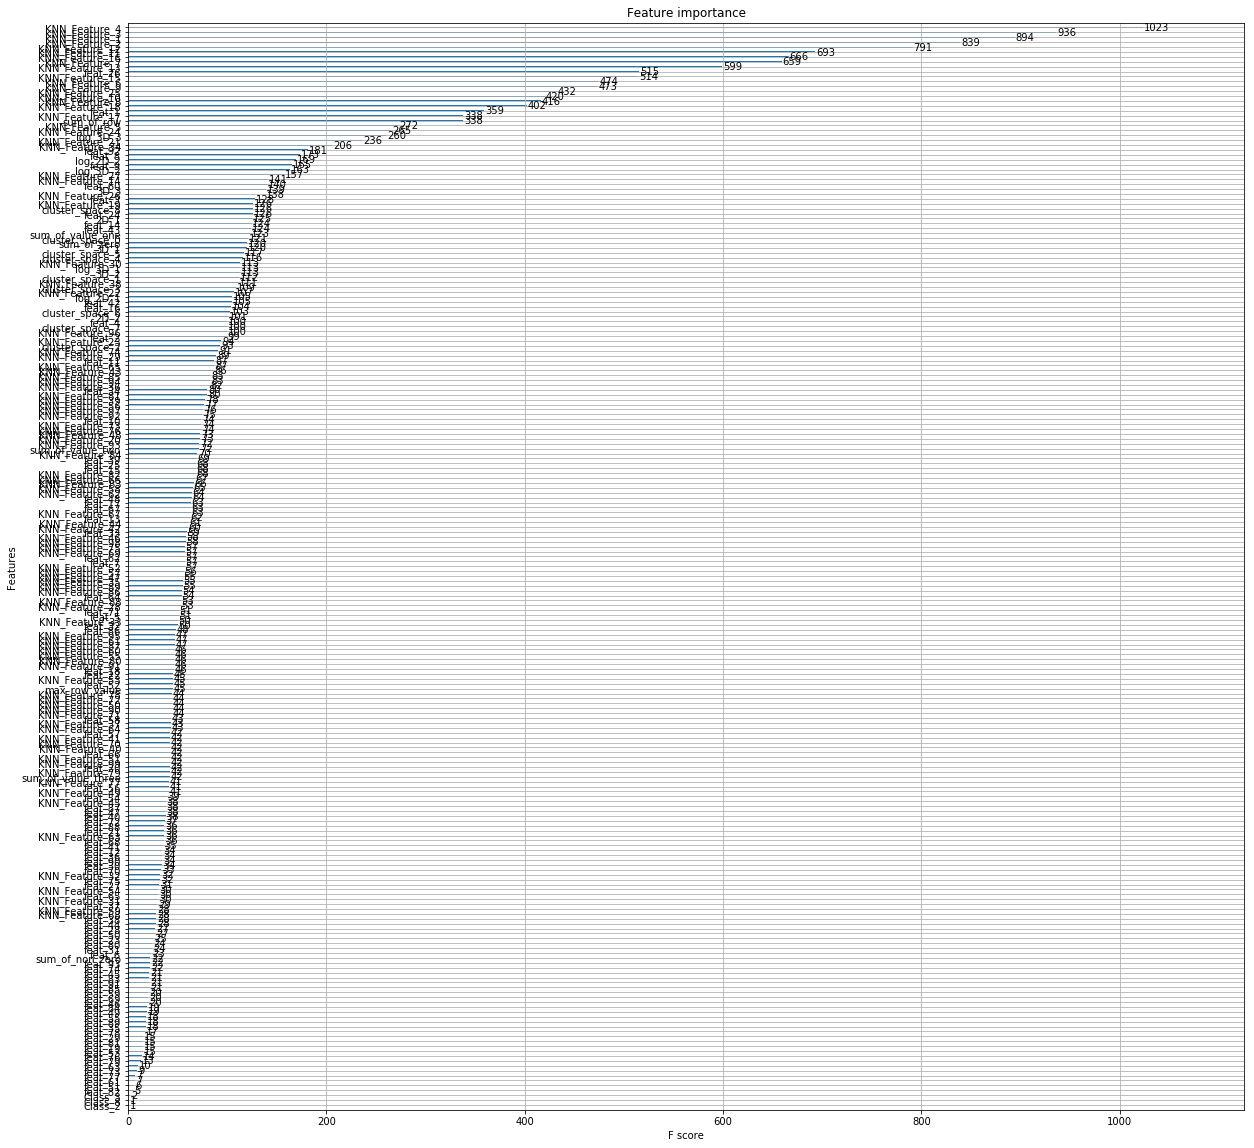

In [78]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [79]:
XGBoost_test_x_eng_pred = xgbFinal.predict(xgb.DMatrix(test_x_eng_with_KNN_TSNE_Kmean))

In [80]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_eng_pred

In [81]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_eng_pred.csv",index=False)

# XGBoost_train_x_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [82]:
XGBoost_train_x_eng_pred = xgbFinal.predict(xgb.DMatrix(train_x_eng_with_KNN_TSNE_KMean))

In [83]:
XGBoost_train_x_eng_pred = pd.DataFrame(XGBoost_train_x_eng_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [84]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_eng_pred.to_csv("XGBoost_train_x_eng_pred.csv",index=False)

# Saving the final model

In [85]:
pickle.dump(xgbFinal, open("XGBoost_train_x_eng_model.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_eng_model = pickle.load(open("XGBoost_train_x_eng_model.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_eng_model_pred = XGBoost_train_x_eng_model.predict(xgb.DMatrix(test_x_log))

# 4. XGBoost, Grid Search with 
# train_x_log_eng_with_KNN_TSNE_KMean, train_y_label

In [86]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

In [87]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [88]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0],                       # 3rd
                          'max_depth': [6],                     # 1st to tune
                          'min_child_weight': [0],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.78],                   # 4th
                          'colsample_bytree': [0.78],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [0],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [256],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["multi:softprob"],
                          "eval_metric": ["mlogloss"],
                          "num_class": [9],
                          "seed": [0]
                         }                

In [89]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBClassifier()

In [90]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 4, iid = False)

In [91]:
xgboost_grid.fit(train_x_log_eng_with_KNN_TSNE_KMean,train_y_label)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0], 'max_depth': [6], 'min_child_weight': [0], 'max_delta_step': [0], 'subsample': [0.78], 'colsample_bytree': [0.78], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [0], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [256], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['multi:softprob'], 'eval_metric': ['mlogloss'], 'num_class': [9], 'seed': [0]},
       pr

In [92]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_accuracy_score = best_rf.score(train_x_log_eng_with_KNN_TSNE_KMean,train_y_label)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_accuracy_score)
print(best_score)
print(best_accuracy_score)
print(best_rf)

0.9025666721463075
0.9891884029865219
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)


In [93]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[0.9025666721463075]
[0.9891884029865219]
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.78, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0, missing=None, n_estimators=256, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1.0,
       seed=0, silent=None, subsample=0.78, verbosity=1)]


# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [94]:
XGBoost_test_x_log_eng_prior_pred = best_rf.predict_proba(test_x_log_eng_with_KNN_TSNE_Kmean)

In [95]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_prior_pred

In [96]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_prior_pred.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model before optimize boosting

In [97]:
XGBoost_train_x_log_eng_prior_pred = best_rf.predict_proba(train_x_log_eng_with_KNN_TSNE_KMean)

In [98]:
XGBoost_train_x_log_eng_prior_pred = pd.DataFrame(XGBoost_train_x_log_eng_prior_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [99]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_prior_pred.to_csv("XGBoost_train_x_log_eng_prior_pred.csv",index=False)

# Create XGBoost's DMatrix, to boosting up the learning rate

In [100]:
trainDMat = xgb.DMatrix(data = train_x_log_eng_with_KNN_TSNE_KMean, label = train_y_label)

In [101]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [102]:
hyperparameters_boosting = {'learning_rate': 0.1,               # 6th when boosting
                          'gamma': 0,                       # 3rd
                          'max_depth': 6,                     # 1st to tune
                          'min_child_weight': 0,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.78,                   # 4th
                          'colsample_bytree': 0.78,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 0,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 256,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "multi:softprob",
                          "eval_metric": "mlogloss",
                          "num_class": 9,
                          "seed": 0
                         }                

In [103]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 4, #same as CV
    metrics = {'merror'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-merror:0.087317+0.00218579	test-merror:0.101054+0.00292165
[1]	train-merror:0.0811058+0.00109609	test-merror:0.0987587+0.00270625
[2]	train-merror:0.0784018+0.00125574	test-merror:0.098533+0.00307839
[3]	train-merror:0.075245+0.00112209	test-merror:0.0966417+0.00227075
[4]	train-merror:0.0732085+0.00150879	test-merror:0.0961892+0.00224154
[5]	train-merror:0.0713877+0.00172334	test-merror:0.0960922+0.00248787
[6]	train-merror:0.0701217+0.00176207	test-merror:0.0957533+0.00217634
[7]	train-merror:0.0686565+0.00170974	test-merror:0.09585+0.00190933
[8]	train-merror:0.067186+0.00135579	test-merror:0.0954945+0.00190814
[9]	train-merror:0.0664805+0.00114829	test-merror:0.0958337+0.00194092
[10]	train-merror:0.065295+0.0013545	test-merror:0.0954135+0.00188847
[11]	train-merror:0.0647132+0.00132451	test-merror:0.0951712+0.00156637
[12]	train-merror:0.0638678+0.00150309	test-merror:0.0949612+0.000999457
[13]	train-merror:0.0633237+0.00139424	test-merror:0.0943145+0.00107475
[14]	train

# Finalise XGBoost Model

In [104]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

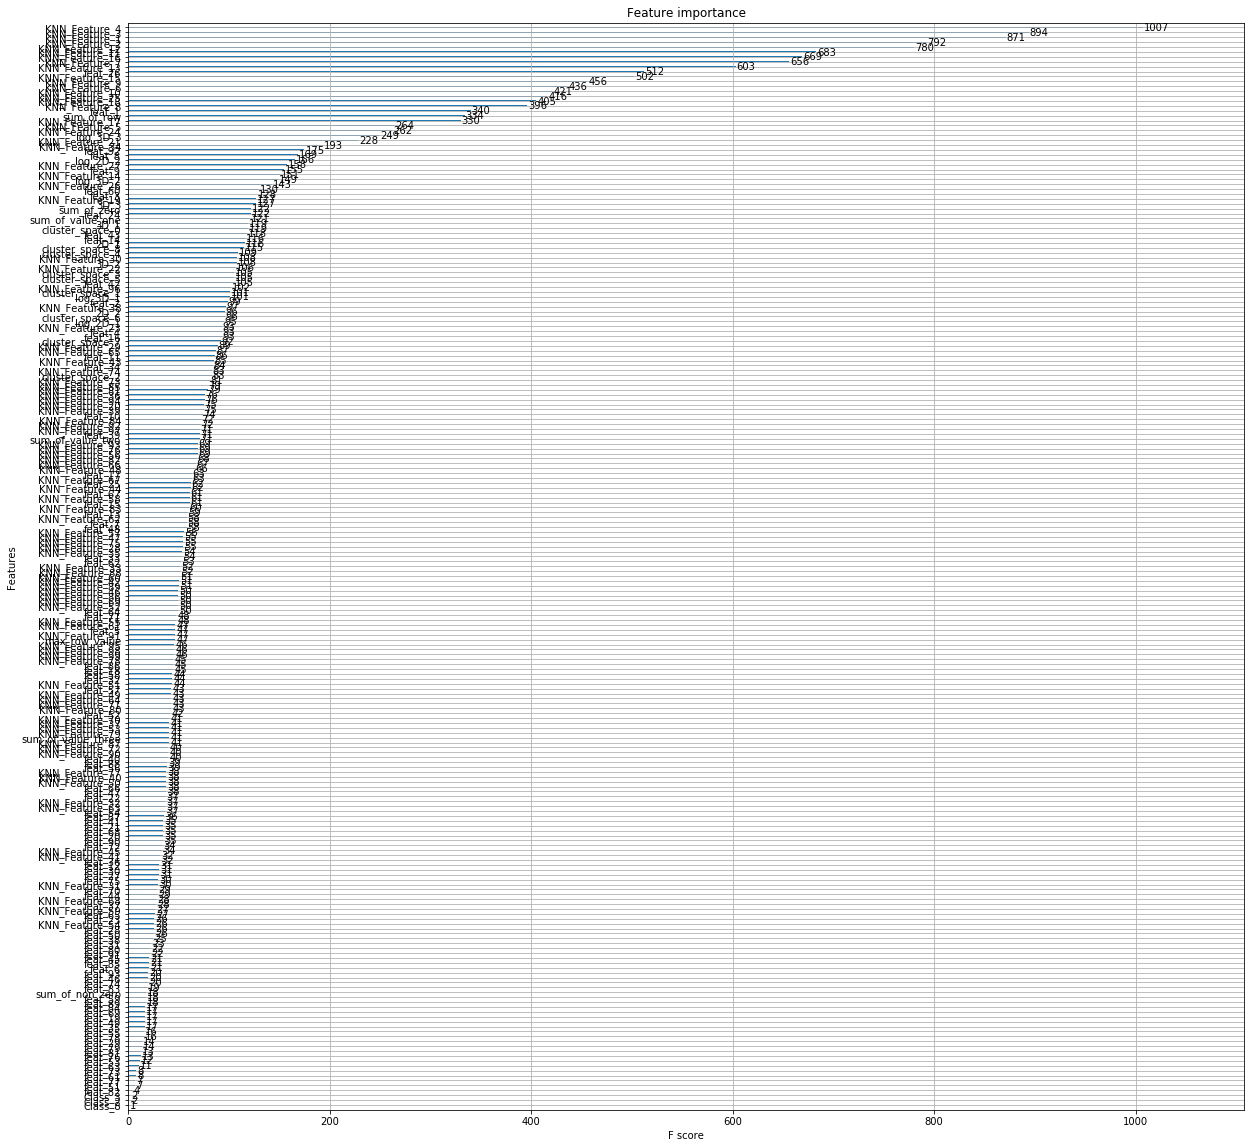

In [105]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# XGBoost_test_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [106]:
XGBoost_test_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(test_x_log_eng_with_KNN_TSNE_Kmean))

In [107]:
Submission = pd.read_csv("sampleSubmission.csv")
Submission[['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']] = XGBoost_test_x_log_eng_pred

In [108]:
## Creating a Submission File to submit to Kaggle competition ##
Submission.to_csv("XGBoost_test_x_log_eng_pred.csv",index=False)

# XGBoost_train_x_log_eng_with_KNN_TSNE_Kmean Prediction for Ensemble Model After optimize boosting

In [109]:
XGBoost_train_x_log_eng_pred = xgbFinal.predict(xgb.DMatrix(train_x_log_eng_with_KNN_TSNE_KMean))

In [110]:
XGBoost_train_x_log_eng_pred = pd.DataFrame(XGBoost_train_x_log_eng_pred, columns = [['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9']])

In [111]:
## Creating a Submission File to submit to Kaggle competition ##
XGBoost_train_x_log_eng_pred.to_csv("XGBoost_train_x_log_eng_pred.csv",index=False)

# Saving the final model

In [112]:
pickle.dump(xgbFinal, open("XGBoost_train_x_log_eng_model.pickle.dat", "wb"))

# Loading the final model

In [ ]:
XGBoost_train_x_log_eng_model = pickle.load(open("XGBoost_train_x_log_eng_model.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
XGBoost_train_x_log_eng_model_pred = XGBoost_train_x_log_eng_model.predict(xgb.DMatrix(test_x_log_eng_with_KNN_TSNE_Kmean))